In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as ss
import matplotlib 
import pickle
import os
import re

In [17]:
# Cell to contain all functions
def rename_columns(dataframe):
    """
    Function to remove spaces from column names and
    change to lowercase.
    """
    df = dataframe
    cols = [c.replace(" ", "_").lower() for c in df.columns]
    cols[3] = "modified_sequence"
    df.columns = cols

def map_sample_names(dataframe):
    """
    Function to map sample names from file names.
    By default, the dataframe will contain the raw file titles; this 
    function removes common prefix and suffixes.
    """
    df = dataframe
    samples = list(set(df.file_name))
    regs = [r"\d*\_DIA\_", r"\.raw", r"\-"]
    res = {}
    for sample in samples:
        new_name = sample
        for reg in regs:
            new_name = re.sub(reg, "", new_name)
        if new_name not in res:
            res[sample] = new_name.lower()
    df.file_name = df.file_name.map(res)

def df_reduce_samples(samples, dataframe):
    """
    Function that takes a master dataframe and returns
    a reduced dataframe containing only rows originating from the 
    samples provided.

    attrs: 
            samples (list)
            dataframe (pd.DataFrame)
    """
    df = dataframe
    return df[df.file_name.isin(samples)]

def pep_in_x_samples(peptide, mz, x, sample_list, dataframe):
    """
    Function that looks for peptide occurrences within a list of samples.
    If the peptide has a frequency greater than x, the function returns true,
    along with the indeces of relevant rows. Indices may be discarded or used 
    to construct a new dataframe.

    attrs:
            peptide (str): peptide string found in dataframe (df.peptide_sequence or 
                                                              df.modified sequence)
            mz (float)   : the mz desired for given peptide (needed when multiple charge
                                                             states exist)
            x (float)    : the frequency at which peptides must occur within the samples
                           (x = 1.0 implies peptide will be in all samples)
            sample_list (list)
            dataframe (pd.DataFrame)
    """
    assert isinstance(x, float) and x > 0 and x <= 1
    df = dataframe
    df = df[(df.modified_sequence==peptide) & 
            (df.precursor_mz==mz) & 
            (df.total_area_ms1 != 0)]
    return len(set(df.file_name))/len(set(sample_list)) >= x, df.index.tolist()

def get_most_intense_charge(peptide, dataframe):
    """
    Function that takes in a peptide sequence and returns the row index 
    for the observation of the charrge state with the highest intensity.

    attrs:
            peptide (str):          peptide string from dataframe
            dataframe (pd.DataFrame)
    """
    df = dataframe
    df = df[df.modified_sequence==peptide]
    intensity = (df.total_area_ms1.describe()["max"])
    z = df[df.total_area_ms1==intensity]["precursor_charge"].item()
    return df[df.precursor_charge==z].index.tolist()

def collapse_proteins(sample_list, dataframe):
    """
    Function that sums MS1 total area from peptides belonging to
    the same protein.

    """
    df = dataframe
    proteins = list(set(df.protein_name))
    top = {}
    for sample in sample_list:
        base = {}
        sub = df[df.file_name==sample]
        proteins = list(set(df.protein_name))
        for protein in proteins:
            sub2 = sub[sub.protein_name==protein]
            base[protein] = sub2.total_area_ms1.sum()
        top[sample] = base 
    return pd.DataFrame(top)

def reduce_axis_labels(ax, factor, vert):
    """
    Function to reduce the number of ticks provided on the pyplot.

    attrs:
            ax (axes.subplot):      current working axis
            factor (int)     :      every nth element will be displayed
                                    on the axes subplot
            vert (str)       :      axes ('x' or 'y') to be changed 
    """

    if vert.lower() == "x":
        plt.setp(ax.xaxis.get_ticklabels(), visible=False)    
        for label in ax.xaxis.get_ticklabels()[factor-1::factor]:        
            label.set_visible(True)
    elif vert.lower() == "y":
        plt.setp(ax.yaxis.get_ticklabels(), visible=False)    
        for label in ax.yaxis.get_ticklabels()[factor-1::factor]:        
            label.set_visible(True)

def has_x_peptides(dataframe, x, sample_list):
    """
    Function to return indices of proteins that contain more
    than x peptides.

    attrs:
            dataframe (pd.DataFrame)
            x (int)                 : number of peptides required
            sample_list (list)      : list of samples within dataframe
    """
    df = dataframe
    counts = df.protein_name.value_counts()/len(sample_list)
    return df[df.protein_name.isin(counts[counts>=x].index)]

def remove_outliers(array, max_devs=2):
    """
    Function to remove outliers from numpy arrays that are more than
    max_devs*standard_deviation away from the average.

    attrs:
            array (np.array)
            max_devs (int)  : number of deviations away from average
                              a point may lie before being removed
    """

    mean = np.mean(array)
    std_dev = np.std(array)
    dist = abs(array-mean)
    not_outlier = dist < max_devs * std_dev
    return np.where(dist < max_devs * std_dev)

def clean_arrays(xs, ys):
    """
    Super function to take in x and y data and perform 
    func=(remove_outliers())
    """
    val_x = remove_outliers(np.log2(xs), 2)[0]
    val_y = remove_outliers(np.log2(ys), 2)[0]
    ids = [i for i in val_x if i in val_y]
    return ids

def has_x_transitions(peptide, mz, x, samples, dataframe):
    """
    Function to scrape dataframe for peptides that contain x number of 
    fragments/transitions.

    Returns bool and indices of three most intense transitions.

    attrs:
            peptide (str): peptide string found in dataframe (df.peptide_sequence or 
                                                              df.modified sequence)
            mz (float)   : the mz desired for given peptide (needed when multiple charge
                                                             states exist)
            x (float)    : the frequency at which peptides must occur within the samples
                           (x = 1.0 implies peptide will be in all samples)
            samples (list)
            dataframe (pd.DataFrame)
    """
    df = dataframe
    df = df[(df.area>0) & (df.peptide_sequence==peptide) &
            (df.precursor_mz==mz) & (df.file_name.isin(samples))]
    df = df.sort_values(["file_name", "area"], ascending=False)
    counts = df.file_name.value_counts().values
    num_trans = sum(counts)
    trans = []
    if len(counts)==len(samples) and (num_trans//len(samples)) >= x:
        for s in samples:
            sub = df[df.file_name==s]
            trans.extend(sub.index[:3])
        return True, trans
    return False, trans

def sum_transitions(samples, dataframe):
    """
    Function that sums the intensity from each major transiiton for a given
    protein within a sample.
    """
    df = dataframe
    master = {}
    for sample in samples:
        slave = {}
        sub = df[df.file_name==sample]
        for r in zip(sub.protein_name, sub.area):
            prot, area = r[0], r[1]
            if not prot in slave:
                slave[prot] = area
            else:
                slave[prot] += area
        master[sample] = slave
    return pd.DataFrame(master)

In [18]:
file = r"E:\Research\Data Workup\CSF_Skyline_Quant_20200124\01272020_CSF_DIA_Top2top3_0.6_0.6.csv"
df = pd.read_csv(file)
rename_columns(df)
map_sample_names(df)
ms1 = df[df.fragment_ion=="precursor"]
ms1.head()

,file_name,protein_name,peptide_sequence,modified_sequence,precursor_mz,precursor_charge,fragment_ion,area,total_area_ms1,total_area_fragment
0,ctrl1_rep1,sp|A0A0A0MS15|HV349_HUMAN,SIAYLQMNSLK,SIAYLQMNSLK,634.33938,2,precursor,23859698,53500528,257655808
1,ctrl1_rep2,sp|A0A0A0MS15|HV349_HUMAN,SIAYLQMNSLK,SIAYLQMNSLK,634.33938,2,precursor,29800830,100641864,35892984
2,ctrl2_rep1,sp|A0A0A0MS15|HV349_HUMAN,SIAYLQMNSLK,SIAYLQMNSLK,634.33938,2,precursor,151988,3895099,99978976
3,ctrl2_rep2,sp|A0A0A0MS15|HV349_HUMAN,SIAYLQMNSLK,SIAYLQMNSLK,634.33938,2,precursor,0,3212994,398603584
4,ctrl3_rep1,sp|A0A0A0MS15|HV349_HUMAN,SIAYLQMNSLK,SIAYLQMNSLK,634.33938,2,precursor,1483501,4060443,214149616


In [19]:
control_samples = ["ctrl1_rep1", "ctrl1_rep2", "ctrl2_rep2",
           "ctrl3_rep1", "ctrl3_rep2"]
sub_ms1 = df_reduce_samples(control_samples, ms1)
reduced = sub_ms1[["modified_sequence", "precursor_mz"]].drop_duplicates()

idxs = []
for r in zip(reduced.modified_sequence, reduced.precursor_mz):
    sequence, mz = r[0], r[1]
    in_all, indexes = pep_in_x_samples(sequence, mz, 0.5, control_samples, sub_ms1)
    if in_all:
        idxs.extend(indexes)
control_peptides = sub_ms1.loc[idxs, :]

charge_red_idx = []
for pep in list(set(control_peptides.modified_sequence)):
    z = get_most_intense_charge(pep, control_peptides)
    charge_red_idx.extend(z)
control_peptides = control_peptides.loc[charge_red_idx, :]

control_collapse = collapse_proteins(control_samples, control_peptides)

In [20]:
ad_samples = ["ad1_rep1", "ad1_rep2", "ad2_rep1",
           "ad1_rep2", "ad3_rep1", "ad3_rep2"]
sub_ms1 = df_reduce_samples(ad_samples, ms1)
reduced = sub_ms1[["modified_sequence", "precursor_mz"]].drop_duplicates()

idxs = []
for r in zip(reduced.modified_sequence, reduced.precursor_mz):
    sequence, mz = r[0], r[1]
    in_all, indexes = pep_in_x_samples(sequence, mz, 0.5, ad_samples, sub_ms1)
    if in_all:
        idxs.extend(indexes)
ad_peptides = sub_ms1.loc[idxs, :]

charge_red_idx = []
for pep in list(set(ad_peptides.modified_sequence)):
    z = get_most_intense_charge(pep, ad_peptides)
    charge_red_idx.extend(z)
ad_peptides = ad_peptides.loc[charge_red_idx, :]

ad_collapse = collapse_proteins(ad_samples, ad_peptides)

In [21]:
mci_samples = ["mci1_rep1", "mci1_rep2", "mci2_rep1",
           "mci1_rep2", "mci3_rep1", "mci3_rep2"]
sub_ms1 = df_reduce_samples(mci_samples, ms1)
reduced = sub_ms1[["modified_sequence", "precursor_mz"]].drop_duplicates()

idxs = []
for r in zip(reduced.modified_sequence, reduced.precursor_mz):
    sequence, mz = r[0], r[1]
    in_all, indexes = pep_in_x_samples(sequence, mz, 0.5, mci_samples, sub_ms1)
    if in_all:
        idxs.extend(indexes)
mci_peptides = sub_ms1.loc[idxs, :]

charge_red_idx = []
for pep in list(set(mci_peptides.modified_sequence)):
    z = get_most_intense_charge(pep, mci_peptides)
    charge_red_idx.extend(z)
mci_peptides = mci_peptides.loc[charge_red_idx, :]

mci_collapse = collapse_proteins(mci_samples, mci_peptides)

In [22]:
ad_compare = ad_collapse[ad_collapse.index.isin(control_collapse.index)].sort_index()
control_compare = control_collapse[control_collapse.index.isin(ad_collapse.index)].sort_index()
ad_compiled = pd.concat([control_compare, ad_compare], axis=1)
p_vals = []
ratios = []
for row in ad_compiled.index:
    ad_vals = ad_compiled.loc[row, ad_samples].values
    control_vals = ad_compiled.loc[row, control_samples].values
    t, p = ss.ttest_ind(control_vals, ad_vals)
    ratio = sum(ad_vals)/sum(control_vals)
    p_vals.append(p)
    ratios.append(ratio)
ad_compiled["protein_ratio"] = ratios
ad_compiled["p_vals"] = p_vals
print(f"Average ratio between AD and Control (freq>=0.5): {ad_compiled.protein_ratio.mean()}")


Average ratio between AD and Control (freq>=0.5): 1.9860899382569208


In [23]:
mci_compare = mci_collapse[mci_collapse.index.isin(control_collapse.index)].sort_index()
control_compare = control_collapse[control_collapse.index.isin(mci_collapse.index)].sort_index()
mci_compiled = pd.concat([control_compare, mci_compare], axis=1)
p_vals = []
ratios = []
for row in mci_compiled.index:
    ad_vals = mci_compiled.loc[row, mci_samples].values
    control_vals = mci_compiled.loc[row, control_samples].values
    t, p = ss.ttest_ind(control_vals, ad_vals)
    ratio = sum(ad_vals)/sum(control_vals)
    p_vals.append(p)
    ratios.append(ratio)
mci_compiled["protein_ratio"] = ratios
mci_compiled["p_vals"] = p_vals
print(f"Average ratio between AD and Control (freq>=0.5): {mci_compiled.protein_ratio.mean()}")

with pd.ExcelWriter("MS1_ratios_pvals_freq0.5.xlsx") as writer:    
    ad_compiled.to_excel(writer, 'AD vs. Ctrl')  
    mci_compiled.to_excel(writer, 'MCI vs. Ctrl')      
    writer.save()


Average ratio between AD and Control (freq>=0.5): 1.2570763064276622


In [24]:
control_samples = ["ctrl1_rep1", "ctrl1_rep2", "ctrl2_rep2",
           "ctrl3_rep1", "ctrl3_rep2"]
sub_ms1 = df_reduce_samples(control_samples, ms1)
reduced = sub_ms1[["modified_sequence", "precursor_mz"]].drop_duplicates()

idxs = []
for r in zip(reduced.modified_sequence, reduced.precursor_mz):
    sequence, mz = r[0], r[1]
    in_all, indexes = pep_in_x_samples(sequence, mz, 1.0, control_samples, sub_ms1)
    if in_all:
        idxs.extend(indexes)
control_peptides = sub_ms1.loc[idxs, :]

charge_red_idx = []
for pep in list(set(control_peptides.modified_sequence)):
    z = get_most_intense_charge(pep, control_peptides)
    charge_red_idx.extend(z)
control_peptides = control_peptides.loc[charge_red_idx, :]

control_collapse = collapse_proteins(control_samples, control_peptides)

In [25]:
ad_samples = ["ad1_rep1", "ad1_rep2", "ad2_rep1",
           "ad1_rep2", "ad3_rep1", "ad3_rep2"]
sub_ms1 = df_reduce_samples(ad_samples, ms1)
reduced = sub_ms1[["modified_sequence", "precursor_mz"]].drop_duplicates()

idxs = []
for r in zip(reduced.modified_sequence, reduced.precursor_mz):
    sequence, mz = r[0], r[1]
    in_all, indexes = pep_in_x_samples(sequence, mz, 1.0, ad_samples, sub_ms1)
    if in_all:
        idxs.extend(indexes)
ad_peptides = sub_ms1.loc[idxs, :]

charge_red_idx = []
for pep in list(set(ad_peptides.modified_sequence)):
    z = get_most_intense_charge(pep, ad_peptides)
    charge_red_idx.extend(z)
ad_peptides = ad_peptides.loc[charge_red_idx, :]

ad_collapse = collapse_proteins(ad_samples, ad_peptides)

In [26]:
mci_samples = ["mci1_rep1", "mci1_rep2", "mci2_rep1",
           "mci1_rep2", "mci3_rep1", "mci3_rep2"]
sub_ms1 = df_reduce_samples(mci_samples, ms1)
reduced = sub_ms1[["modified_sequence", "precursor_mz"]].drop_duplicates()

idxs = []
for r in zip(reduced.modified_sequence, reduced.precursor_mz):
    sequence, mz = r[0], r[1]
    in_all, indexes = pep_in_x_samples(sequence, mz, 1.0, mci_samples, sub_ms1)
    if in_all:
        idxs.extend(indexes)
mci_peptides = sub_ms1.loc[idxs, :]

charge_red_idx = []
for pep in list(set(mci_peptides.modified_sequence)):
    z = get_most_intense_charge(pep, mci_peptides)
    charge_red_idx.extend(z)
mci_peptides = mci_peptides.loc[charge_red_idx, :]

mci_collapse = collapse_proteins(mci_samples, mci_peptides)

In [27]:
ad_compare = ad_collapse[ad_collapse.index.isin(control_collapse.index)].sort_index()
control_compare = control_collapse[control_collapse.index.isin(ad_collapse.index)].sort_index()
ad_compiled = pd.concat([control_compare, ad_compare], axis=1)
p_vals = []
ratios = []
for row in ad_compiled.index:
    ad_vals = ad_compiled.loc[row, ad_samples].values
    control_vals = ad_compiled.loc[row, control_samples].values
    t, p = ss.ttest_ind(control_vals, ad_vals)
    ratio = sum(ad_vals)/sum(control_vals)
    p_vals.append(p)
    ratios.append(ratio)
ad_compiled["protein_ratio"] = ratios
ad_compiled["p_vals"] = p_vals
print(f"Average ratio between AD and Control (freq=1.0): {ad_compiled.protein_ratio.mean()}")

Average ratio between AD and Control (freq=1.0): 2.5917393956758055


In [28]:
mci_compare = mci_collapse[mci_collapse.index.isin(control_collapse.index)].sort_index()
control_compare = control_collapse[control_collapse.index.isin(mci_collapse.index)].sort_index()
mci_compiled = pd.concat([control_compare, mci_compare], axis=1)
p_vals = []
ratios = []
for row in mci_compiled.index:
    ad_vals = mci_compiled.loc[row, mci_samples].values
    control_vals = mci_compiled.loc[row, control_samples].values
    t, p = ss.ttest_ind(control_vals, ad_vals)
    ratio = sum(ad_vals)/sum(control_vals)
    p_vals.append(p)
    ratios.append(ratio)
mci_compiled["protein_ratio"] = ratios
mci_compiled["p_vals"] = p_vals
print(f"Average ratio between AD and Control (freq=1.0): {mci_compiled.protein_ratio.mean()}")

with pd.ExcelWriter("MS1_ratios_pvals_freq1.0.xlsx") as writer:    
    ad_compiled.to_excel(writer, 'AD vs. Ctrl')  
    mci_compiled.to_excel(writer, 'MCI vs. Ctrl')      
    writer.save()
    

Average ratio between AD and Control (freq=1.0): 1.3786631440610901


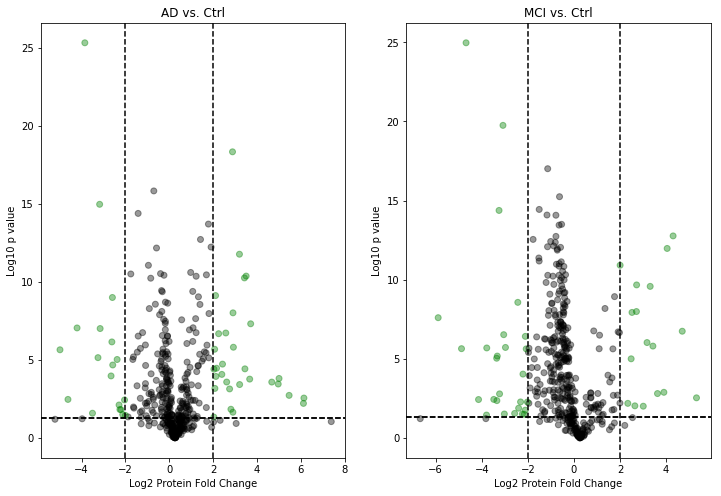

In [59]:
adp = pd.read_excel("MS1_ratios_pvals_freq1.0.xlsx", sheet_name="AD vs. Ctrl")
mcip = pd.read_excel("MS1_ratios_pvals_freq1.0.xlsx", sheet_name="MCI vs. Ctrl")
adp["log_fold"] = np.log2(adp.protein_ratio)
adp["log_p"] = np.log(adp.p_vals)*-1
mcip["log_fold"] = np.log2(mcip.protein_ratio)
mcip["log_p"] = np.log(mcip.p_vals)*-1
a_xs = np.log2(adp.protein_ratio)
a_ys = np.log(adp.p_vals)*-1
m_xs = np.log2(mcip.protein_ratio)
m_ys = np.log(mcip.p_vals)*-1
a_colors = ["g" if (p[0]>=2 and p[1]>=1.3) or (p[0]<=-2 and p[1]>=1.3) else "k" for p in zip(a_xs, a_ys)]
m_colors = ["g" if (p[0]>=2 and p[1]>=1.3) or (p[0]<=-2 and p[1]>=1.3) else "k" for p in zip(m_xs, m_ys)]
fig, axs = plt.subplots(1, 2, figsize=(12,8))
axs[0].scatter(a_xs, a_ys, color=a_colors, alpha=0.4)
axs[1].scatter(m_xs, m_ys, color=m_colors, alpha=0.4)
cuts= [[-2, 2], [1.3]]
titles = ["AD vs. Ctrl", "MCI vs. Ctrl"]

for i, ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.set_xlabel("Log2 Protein Fold Change")
    ax.set_ylabel("Log10 p value")
    for v in cuts[0]:
        ax.axvline(x=v, color="k", linestyle="--")
        ax.axhline(y=cuts[1][0], color="k", linestyle="--")

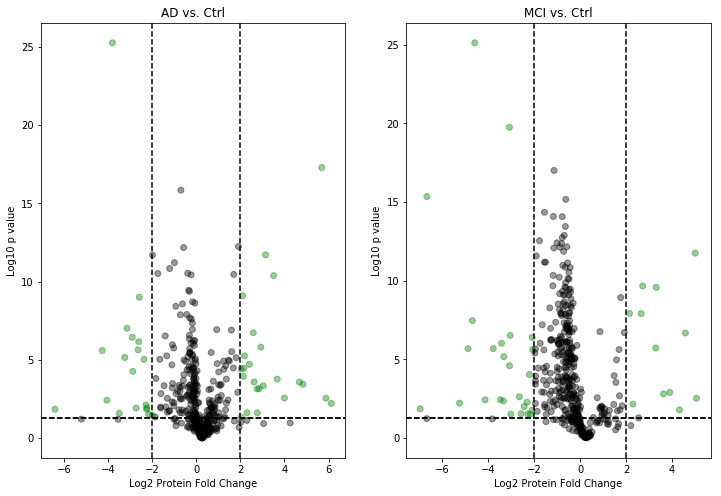

In [60]:
adp = pd.read_excel("MS1_ratios_pvals_freq0.5.xlsx", sheet_name="AD vs. Ctrl")
mcip = pd.read_excel("MS1_ratios_pvals_freq0.5.xlsx", sheet_name="MCI vs. Ctrl")
adp["log_fold"] = np.log2(adp.protein_ratio)
adp["log_p"] = np.log(adp.p_vals)*-1
mcip["log_fold"] = np.log2(mcip.protein_ratio)
mcip["log_p"] = np.log(mcip.p_vals)*-1
a_xs = np.log2(adp.protein_ratio)
a_ys = np.log(adp.p_vals)*-1
m_xs = np.log2(mcip.protein_ratio)
m_ys = np.log(mcip.p_vals)*-1
a_colors = ["g" if (p[0]>=2 and p[1]>=1.3) or (p[0]<=-2 and p[1]>=1.3) else "k" for p in zip(a_xs, a_ys)]
m_colors = ["g" if (p[0]>=2 and p[1]>=1.3) or (p[0]<=-2 and p[1]>=1.3) else "k" for p in zip(m_xs, m_ys)]
fig, axs = plt.subplots(1, 2, figsize=(12,8))
axs[0].scatter(a_xs, a_ys, color=a_colors, alpha=0.4)
axs[1].scatter(m_xs, m_ys, color=m_colors, alpha=0.4)
cuts= [[-2, 2], [1.3]]
titles = ["AD vs. Ctrl", "MCI vs. Ctrl"]

for i, ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.set_xlabel("Log2 Protein Fold Change")
    ax.set_ylabel("Log10 p value")
    for v in cuts[0]:
        ax.axvline(x=v, color="k", linestyle="--")
        ax.axhline(y=cuts[1][0], color="k", linestyle="--")